# Análisis Exploratorio de Datos (EDA): Carcinoma Papilar de Tiroides (TCGA-THCA)
En este notebook realizaremos un análisis exhaustivo del perfil clínico y genómico de pacientes con carcinoma de tiroides. El objetivo es identificar patrones que diferencien los grupos de pacientes y explorar cómo la expresión de ciertos genes se relaciona con el avance de la enfermedad. Primero cargamos las librerias necesarias para el proyecto.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from scipy.stats import chi2_contingency

# Cargar datos clínicos (503 samples x 15 attributes)
df_clinical = pd.read_table('Clinical_Phenotype.tsi', index_col=0)
df_clinical = df_clinical.T # Lo trasponemos para tener muestras en filas

# Cargar datos RNA-seq (Genes x Samples)
df_rna = pd.read_table('RNAseq_Gene_level.cct', index_col=0)
df_rna = df_rna.T  # Lo trasponemos también, así ambos tienen la misma estructura

In [2]:
print(f"Dimensiones Clínicas: {df_clinical.shape}")
print(f"Dimensiones RNA-seq: {df_rna.shape}")
print("Información del archivo clínico:")
print(df_clinical.info())

# Ver las primeras filas
display(df_clinical.head())
display(df_rna.iloc[:5, :5]) # Solo las primeras 5x5 para no saturar la pantalla

Dimensiones Clínicas: (503, 16)
Dimensiones RNA-seq: (501, 19927)
Información del archivo clínico:
<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, TCGA.BJ.A290 to TCGA.E8.A418
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   years_to_birth         503 non-null    object
 1   Tumor_purity           495 non-null    object
 2   pathologic_stage       501 non-null    object
 3   pathology_T_stage      501 non-null    object
 4   pathology_N_stage      453 non-null    object
 5   pathology_M_stage      289 non-null    object
 6   histological_type      503 non-null    object
 7   number_of_lymph_nodes  389 non-null    object
 8   gender                 503 non-null    object
 9   radiation_therapy      487 non-null    object
 10  residual_tumor         441 non-null    object
 11  race                   411 non-null    object
 12  ethnicity              400 non-null    object
 13  overall_sur

attrib_name,years_to_birth,Tumor_purity,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,histological_type,number_of_lymph_nodes,gender,radiation_therapy,residual_tumor,race,ethnicity,overall_survival,status,overallsurvival
TCGA.BJ.A290,70,0.9164,stageiii,t3,n1,m0,thyroidpapillarycarcinoma-tallcell(>=50%tallce...,3,male,yes,NaN,white,nothispanicorlatino,919,0,"919,0"
TCGA.BJ.A291,56,0.9253,stagei,t1,n0,m0,thyroidpapillarycarcinoma-classical/usual,0,female,yes,NaN,white,nothispanicorlatino,696,0,"696,0"
TCGA.BJ.A45K,33,0.9475,stagei,t2,n0,m0,thyroidpapillarycarcinoma-classical/usual,0,male,yes,NaN,white,nothispanicorlatino,705,0,"705,0"
TCGA.CE.A13K,30,0.9431,stagei,t3,n1,m0,thyroidpapillarycarcinoma-classical/usual,2,female,no,r0,asian,nothispanicorlatino,385,0,"385,0"
TCGA.DE.A0XZ,65,0.8013,stageiii,t1,n1,m0,thyroidpapillarycarcinoma-classical/usual,5,female,yes,r0,white,nothispanicorlatino,1090,0,"1090,0"


attrib_name,A1BG,A1CF,A2BP1,A2LD1,A2ML1
TCGA.4C.A93U,6.7783,0.0000,0.0000,6.3423,0.5686
TCGA.BJ.A0YZ,7.9814,0.5023,4.6288,6.0307,0.8742
TCGA.BJ.A0Z0,7.1232,0.0000,2.4177,5.4087,1.3670
TCGA.BJ.A0Z2,8.4094,0.0000,4.7105,6.7106,0.0000
TCGA.BJ.A0Z3,6.7996,0.0000,1.6286,6.5277,0.0000


## 1. Preprocesamiento y Control de Calidad de Datos (RNA-seq & Clínica)
Antes de realizar el análisis estadístico, es fundamental asegurar la integridad y la calidad de los datos. Este proceso se divide en tres fases críticas:
1. Alineamiento de Muestras (Sample Matching)
Los datos provienen de dos fuentes distintas: un archivo de fenotipo clínico (.tsi) y uno de expresión génica (.cct)
- Orientación: Hemos traspuesto ambos DataFrames para obtener una mejor observación.
- Sincronización: Dado que existen 503 muestras clínicas y 501 genéticas, se realiza un Inner Join basado en el identificador único del paciente (attrib_name, presente en ambos archivos de datos). Esto garantiza que solo analizaremos sujetos que cuenten con información completa en ambas ómicas.
2. Interpretación de la Escala Logarítmica
Los valores de RNA-seq están normalizados en escala $\log_2(x + 1)$. Esta transformación es estándar en bioinformática porque:
-Comprime el rango dinámico: Permite comparar genes con niveles de expresión masivos (ej. $13-14$ en escala log) frente a genes de baja abundancia (ej. $1-2$).
- Normaliza la varianza: Mitiga el sesgo de los valores extremos, facilitando la aplicación de modelos lineales y pruebas estadísticas.
3. Criterios de Filtrado de Genes
Para reducir el ruido y aumentar el poder estadístico, filtramos los 19,927 genes originales bajo dos criterios:
- Filtro de Expresión Mínima: Se eliminan genes con una media inferior a 0.5, ya que suelen representar ruido de fondo o genes "apagados" sin relevancia biológica en este tejido.
- Filtro de Varianza (Información): Se descartan los genes con baja variabilidad (inferior al percentil 25). Un gen que no cambia entre pacientes no sirve como biomarcador ni ayuda a diferenciar estadios clínicos.

In [3]:
# Filtrado de genes
print(f"Genes antes del filtrado: {df_rna.shape[1]}") #uso el 1 para que solo me ofrezca el número de columnas, que es el que se va a modificar

# A. Filtro de expresión mínima (Media > 0.5)
mascara_media = df_rna.mean() > 0.5

# B. Filtro de Variabilidad (Varianza > Percentil 25)
mascara_varianza = df_rna.var() > df_rna.var().quantile(0.25)

# Aplicamos ambos filtros al dataframe de RNA directamente
df_rna_filtrado = df_rna.loc[:, mascara_media & mascara_varianza]

print(f"Genes después del filtrado: {df_rna_filtrado.shape[1]}")

Genes antes del filtrado: 19927
Genes después del filtrado: 14058


In [4]:
# Alineamiento (Merge)
df_combined = pd.merge(df_clinical, df_rna_filtrado, left_index=True, right_index=True, how='inner')
# how='inner' elimina automáticamente las 2 muestras sobrantes de la clínica
display(df_combined)

attrib_name,years_to_birth,Tumor_purity,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,histological_type,number_of_lymph_nodes,gender,radiation_therapy,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
TCGA.BJ.A290,70,0.9164,stageiii,t3,n1,m0,thyroidpapillarycarcinoma-tallcell(>=50%tallce...,3,male,yes,...,7.7473,8.3445,5.4073,8.3531,5.1289,10.7296,11.5958,9.7266,10.0651,8.2933
TCGA.BJ.A291,56,0.9253,stagei,t1,n0,m0,thyroidpapillarycarcinoma-classical/usual,0,female,yes,...,5.9979,6.5599,5.4196,7.8035,4.2978,10.0419,10.9372,9.7396,9.0237,9.3920
TCGA.BJ.A45K,33,0.9475,stagei,t2,n0,m0,thyroidpapillarycarcinoma-classical/usual,0,male,yes,...,6.8550,7.6329,6.2115,8.2636,4.8138,10.0425,11.0905,10.7769,9.5262,3.4051
TCGA.CE.A13K,30,0.9431,stagei,t3,n1,m0,thyroidpapillarycarcinoma-classical/usual,2,female,no,...,6.9909,5.7142,6.0066,8.2334,3.8446,10.3619,12.1129,10.2350,9.3924,9.2139
TCGA.DE.A0XZ,65,0.8013,stageiii,t1,n1,m0,thyroidpapillarycarcinoma-classical/usual,5,female,yes,...,7.5596,7.4160,6.0106,8.2551,4.2707,10.4566,11.3216,10.6043,9.9314,7.5806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.MK.A4N6,35,0.8064,stagei,t3,n1,m0,thyroidpapillarycarcinoma-classical/usual,40,male,yes,...,7.5719,7.5342,5.2254,8.5422,5.9968,11.4576,12.1779,10.2055,9.4912,8.6888
TCGA.MK.A4N7,20,0.97,stagei,t2,n0,m0,thyroidpapillarycarcinoma-classical/usual,0,female,yes,...,7.3318,6.8214,5.9486,8.6866,4.0438,10.6519,11.4812,10.1791,9.8751,8.7327
TCGA.MK.A4N9,41,0.9015,stagei,t3,n1,m0,thyroidpapillarycarcinoma-classical/usual,1,female,yes,...,7.3517,6.6130,5.7360,8.2884,2.8934,10.4098,11.9094,10.3361,9.6806,8.3119
TCGA.QD.A8IV,50,0.9133,stageiv,t3,n1,NaN,thyroidpapillarycarcinoma-classical/usual,15,female,yes,...,6.9116,7.5259,6.2881,8.8844,7.4703,10.5517,10.1668,10.5275,9.8784,9.5143


In [5]:
# Veamos la información de las columnas en el nuevo DataFrame (excepto aquellas que corresponden a genes)
df_combined.loc[:, "years_to_birth":"radiation_therapy"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, TCGA.BJ.A290 to TCGA.E8.A418
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   years_to_birth         501 non-null    object
 1   Tumor_purity           493 non-null    object
 2   pathologic_stage       499 non-null    object
 3   pathology_T_stage      499 non-null    object
 4   pathology_N_stage      451 non-null    object
 5   pathology_M_stage      288 non-null    object
 6   histological_type      501 non-null    object
 7   number_of_lymph_nodes  387 non-null    object
 8   gender                 501 non-null    object
 9   radiation_therapy      485 non-null    object
dtypes: object(10)
memory usage: 43.1+ KB


## 2. Análisis Univariante
En esta fase del proyecto, realizamos un Análisis Exploratorio de Datos (EDA) enfocado en la distribución individual de cada variable. El objetivo es comprender la naturaleza de nuestra cohorte antes de establecer relaciones complejas entre la clínica y la genética.
Objetivos de esta sección:
- Cálculo de Cardinalidad: Evaluar la proporción de valores únicos en cada columna mediante la fórmula:
$$Cardinalidad = \frac{\text{Valores Únicos}}{\text{Total de Registros}} \times 100$$
- Distribución de Frecuencias: Examinar cómo se reparten los pacientes según su Estadio Patológico y Género.
- Análisis de Variables Numéricas: Estudiar la distribución de la Edad y la Expresión Media de los genes para detectar posibles sesgos o valores atípicos (outliers).
Esto nos permite descartar variables con cardinalidad próxima al 100% (como IDs de muestras) y centrarnos en variables categóricas con capacidad de agrupación.

In [6]:
# Cálculo de la cardinalidad
df_tipificacion = pd.DataFrame({
    "Card": df_clinical.nunique(),
    "%_Card": (df_clinical.nunique() / len(df_clinical)) * 100
})

# Aplicamos reglas de clasificación personalizadas
# Partimos de la base de que casi todas parecen categóricas
df_tipificacion["Clasificada_como"] = "Categorica" 

# Si tiene exactamente 2 valores  es Binaria
df_tipificacion.loc[df_tipificacion["Card"] == 2, "Clasificada_como"] = "Binaria"

# Si tiene más de 10 valores pero baja cardinalidad relativa, es Numerica Discreta
df_tipificacion.loc[df_tipificacion["Card"] > 10, "Clasificada_como"] = "Numerica Discreta"

# Si la cardinalidad relativa es mayor al 30%, es Numerica Continua
df_tipificacion.loc[df_tipificacion["%_Card"] > 30, "Clasificada_como"] = "Numerica Continua"

print("Resultado de la Tipificación de Variables Clínicas:")
display(df_tipificacion)

Resultado de la Tipificación de Variables Clínicas:


,Card,%_Card,Clasificada_como
attrib_name,,,
years_to_birth,73,14.512922,Numerica Discreta
Tumor_purity,372,73.956262,Numerica Continua
pathologic_stage,4,0.795229,Categorica
pathology_T_stage,4,0.795229,Categorica
pathology_N_stage,2,0.397614,Binaria
pathology_M_stage,2,0.397614,Binaria
histological_type,4,0.795229,Categorica
number_of_lymph_nodes,29,5.765408,Numerica Discreta
gender,2,0.397614,Binaria


Explicar cómo afectará su clasificación a para qué las elijamos

In [7]:
# Configuración estética de los gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

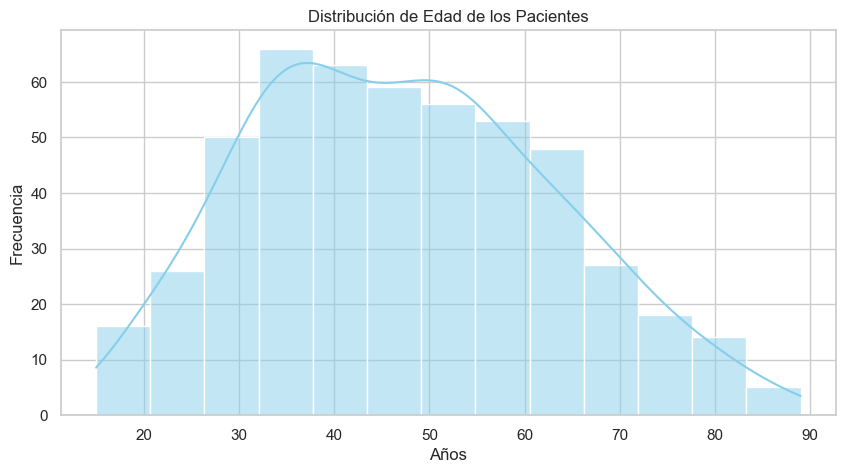

In [8]:
# Distribución de la EDAD
df_combined['years_to_birth'] = pd.to_numeric(df_combined['years_to_birth'], errors='coerce') # Convertimos a numérico por seguridad
plt.figure(figsize=(10, 5))
sns.histplot(data=df_combined, x='years_to_birth', kde=True, color='skyblue')
plt.title('Distribución de Edad de los Pacientes')
plt.xlabel('Años')
plt.ylabel('Frecuencia')
plt.show()

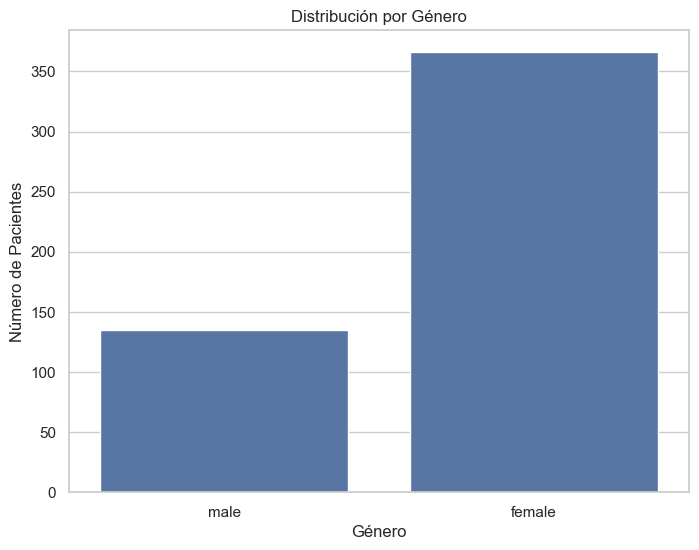

In [9]:
# Distribución de género
plt.figure(figsize=(8, 6))
sns.countplot(data=df_combined, x='gender')

plt.title('Distribución por Género')
plt.ylabel('Número de Pacientes')
plt.xlabel('Género')
plt.show()

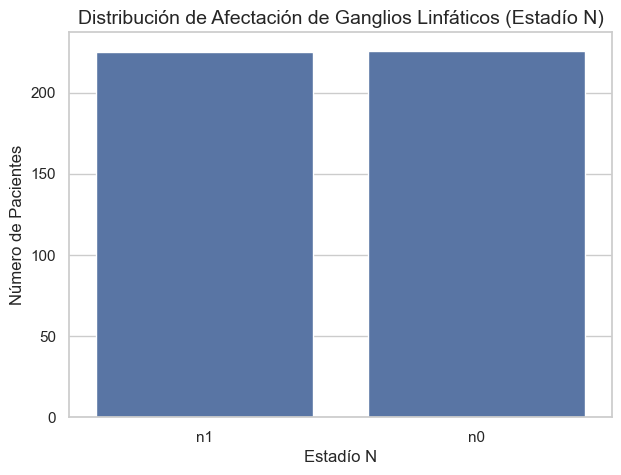

In [10]:
# Distribución de la diseminación (si/no) del cancer a los ganglios linfáticos
plt.figure(figsize=(7, 5))
sns.countplot(data=df_combined, x='pathology_N_stage')


plt.title('Distribución de Afectación de Ganglios Linfáticos (Estadío N)', fontsize=14)
plt.xlabel('Estadío N', fontsize=12)
plt.ylabel('Número de Pacientes', fontsize=12)
plt.xticks(rotation=0) # Asegura que las etiquetas no se roten si no es necesario
plt.show()

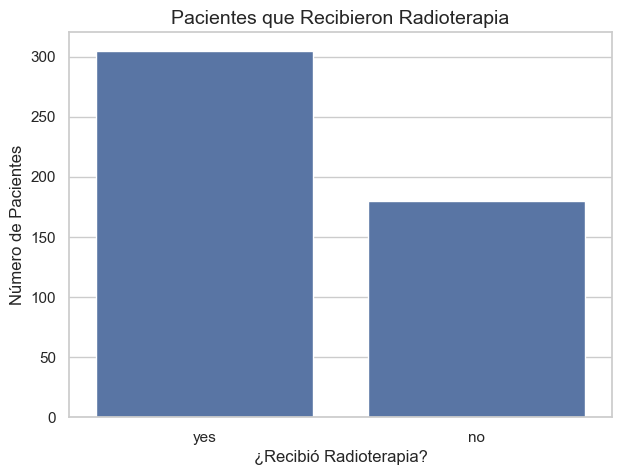

In [11]:
# Distribución de pacientes en función de si recibieron o no radioterapia
plt.figure(figsize=(7, 5))

# Gráfico para radiation_therapy
sns.countplot(data=df_combined, x='radiation_therapy')
plt.title('Pacientes que Recibieron Radioterapia', fontsize=14)
plt.xlabel('¿Recibió Radioterapia?', fontsize=12)
plt.ylabel('Número de Pacientes', fontsize=12)
plt.xticks(rotation=0)
plt.show()

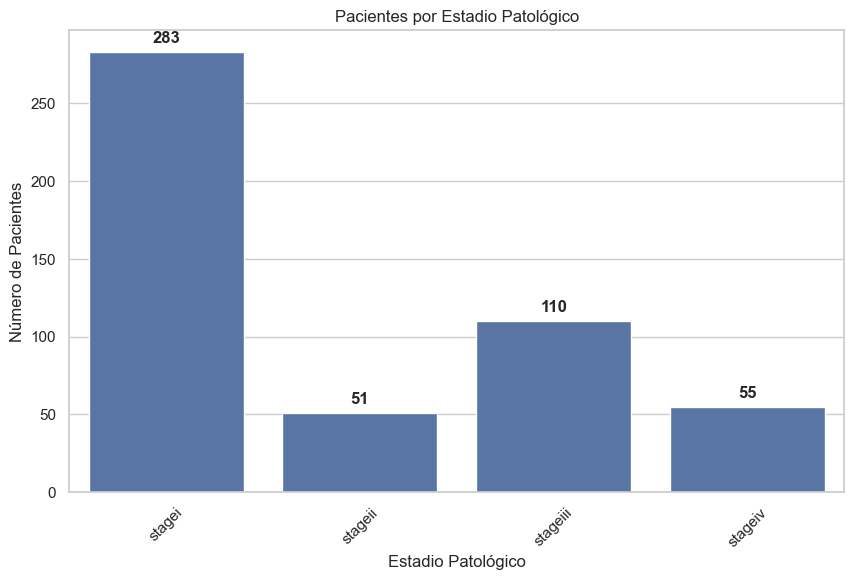

In [12]:
# Distribución por estadío
plt.figure(figsize=(10, 6))

# Definimos el orden clínico correcto
stage_order = ['stagei', 'stageii', 'stageiii', 'stageiv']
ax = sns.countplot(data=df_combined, x='pathologic_stage', order=stage_order)

# Añadir etiquetas de conteo sobre las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

plt.title('Pacientes por Estadio Patológico')
plt.ylabel('Número de Pacientes')
plt.xlabel('Estadio Patológico')
plt.xticks(rotation=45)
plt.show()

Estudiar la expresión genética en función del estadío de la enfermedad diferenciando entre temprano (estadíos I y II) y tardío (III y IV) es una buena opción para proseguir con los análisis bi y multivariantes. (Aún así, hay que tener en cuenta el tamaño de ambas muestras, ya que en el estadío I se concentra mayor nivel de datos, por lo que lo mismo tendríamos que proceder a una normalizacion de los datos.)

Hasta ahora hemos estudiado características clínicas en el análisis univariante, veamos la distribución de la expresión génica.

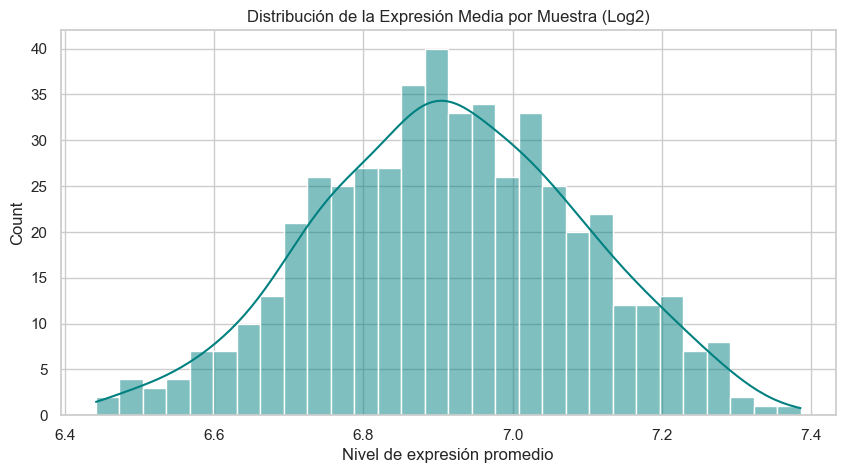

Genes con mayor variabilidad de expresión:
attrib_name
RPS4Y1      26.751166
XIST        25.395785
DDX3Y       19.753860
ARHGAP36    19.514661
KDM5D       19.510072
dtype: float64


In [50]:
# Calculamos la media de expresión de todos los genes por cada muestra
expresion_media = df_rna_filtrado.mean(axis=1)

plt.figure(figsize=(10, 5))
sns.histplot(expresion_media, kde=True, color='teal', bins=30)
plt.title('Distribución de la Expresión Media por Muestra (Log2)')
plt.xlabel('Nivel de expresión promedio')
plt.show()

# Identificar los 5 genes con mayor varianza (potenciales biomarcadores)
genes_varianza = df_rna_filtrado.var().sort_values(ascending=False).head(5)
print("Genes con mayor variabilidad de expresión:")
print(genes_varianza)


Explicar variabilidad

## ANÁLISIS BIVARIANTE

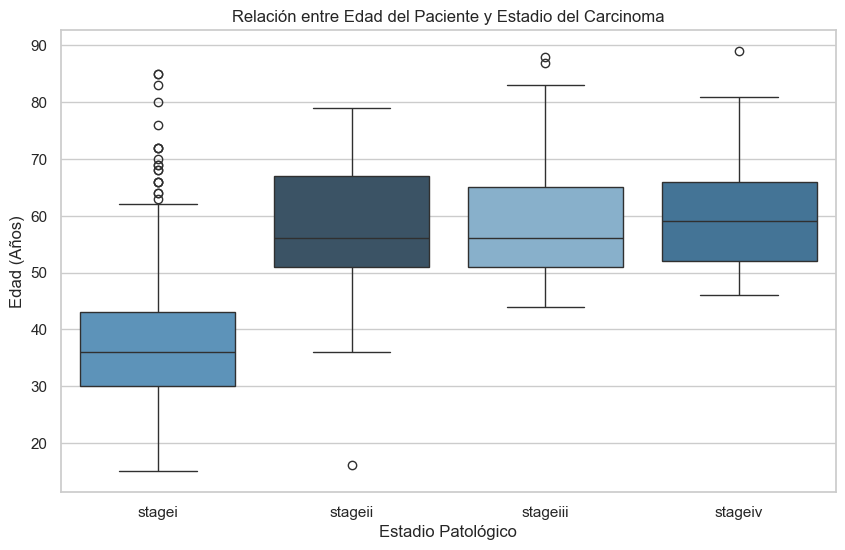

In [14]:
#EDAD VS ESTADIO

plt.figure(figsize=(10, 6))

# Definimos el orden clínico para el eje X
stage_order = ['stagei', 'stageii', 'stageiii', 'stageiv']

# Dibujamos un Boxplot para ver la distribución de edad por estadio
sns.boxplot(data=df_combined, x='pathologic_stage', y='years_to_birth', 
            order=stage_order, palette='Blues_d', hue='pathologic_stage', legend=False)

plt.title('Relación entre Edad del Paciente y Estadio del Carcinoma')
plt.xlabel('Estadio Patológico')
plt.ylabel('Edad (Años)')
plt.show()


NUEVO
explicar que vamos apilar los datos en función de estadíos tempranos vs tardíos, pero hay que normalizar los datos porque hay una mayor cantidad de valores para estadíos tempranos y así no se puede observar bien la diferencia en algunos casos

In [15]:
# Comparar la presencia de nodos con el estadio tumoral
# Crear variable binaria de presencia de nodos (ignorando NAs)
df_combined['number_of_lymph_nodes'] = pd.to_numeric(df_combined['number_of_lymph_nodes'], errors='coerce')
df_combined['has_lymph_nodes'] = df_combined['number_of_lymph_nodes'].apply(
    lambda x: 'Yes' if x > 0 else 'No' if x == 0 else np.nan
)

# Agrupar estadios (Temprano vs Avanzado)
stage_map = {
    'stagei': 'Early (I-II)', 'stageii': 'Early (I-II)',
    'stageiii': 'Advanced (III-IV)', 'stageiv': 'Advanced (III-IV)'
}
df_combined['stage_binary'] = df_combined['pathologic_stage'].map(stage_map)

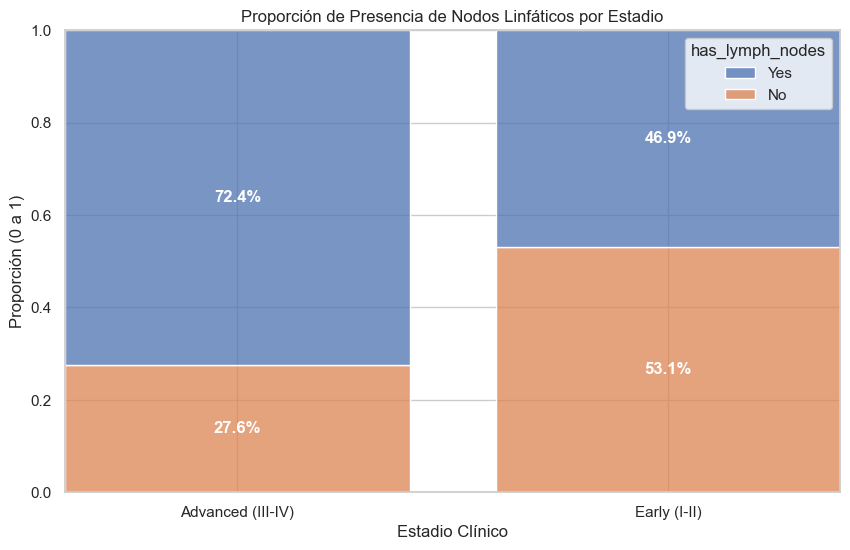

In [16]:
plt.figure(figsize=(10, 6))

ax = sns.histplot(
    data=df_combined.dropna(subset=['stage_binary', 'has_lymph_nodes']),
    x='stage_binary', 
    hue='has_lymph_nodes',
    multiple='fill', 
    shrink=0.8
)

plt.title('Proporción de Presencia de Nodos Linfáticos por Estadio')
plt.ylabel('Proporción (0 a 1)')
plt.xlabel('Estadio Clínico')

# Añadir etiquetas de porcentaje
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Solo poner etiqueta si la barra tiene altura
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + height / 2
        ax.annotate(f'{height:.1%}', 
                    (x, y), 
                    ha='center', 
                    va='center', 
                    color='white', 
                    weight='bold')

**Hacer cálculos estadísticos para mostrar la significancia de los resultados

A PARTIR DE AQUÍ TENGO QUE ARREGLAR/ORDENAR TODO

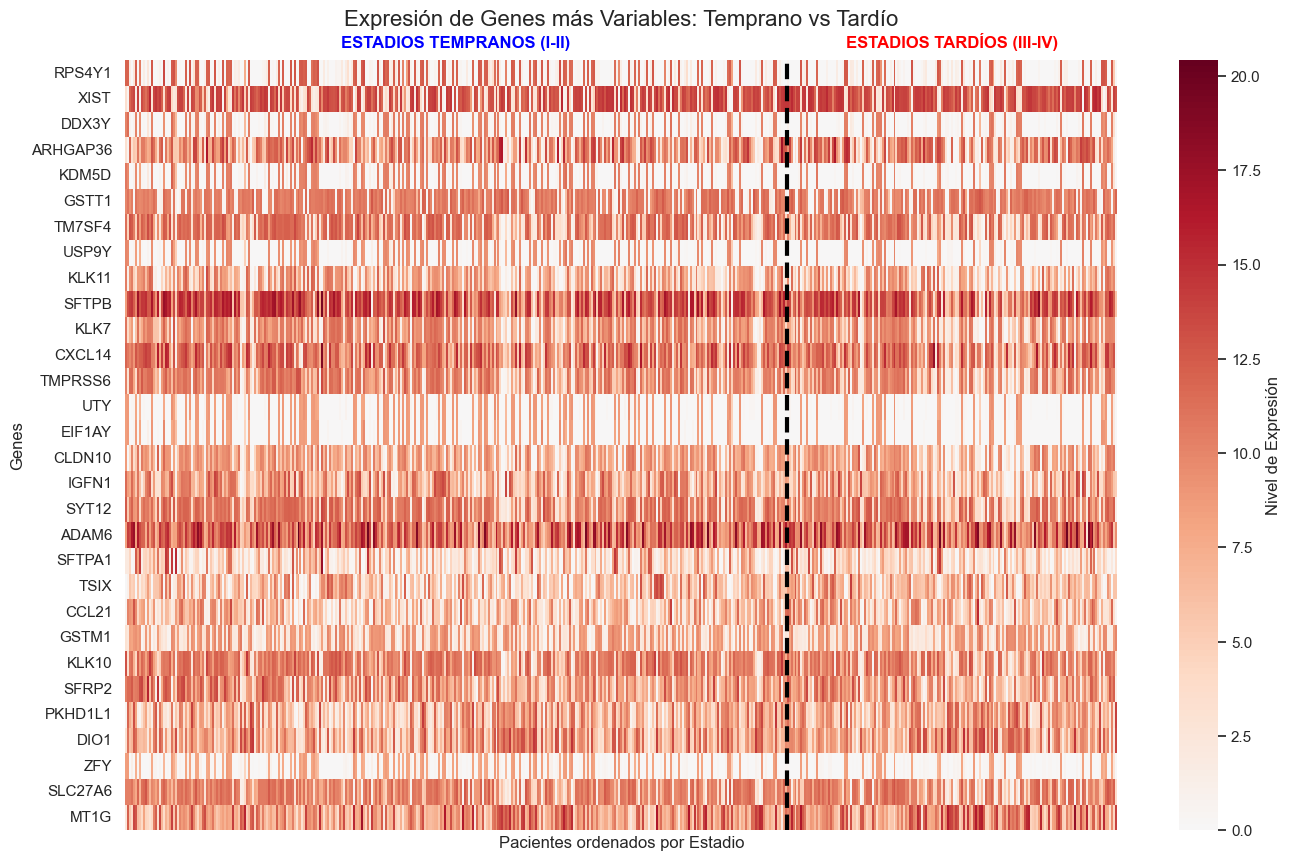

In [19]:
# 1. Agrupación de estadios (Temprano: I-II, Tardío: III-IV)
stage_map = {
    'stagei': 'Temprano', 'stageii': 'Temprano',
    'stageiii': 'Tardío', 'stageiv': 'Tardío'
}
df_combined['stage_group'] = df_combined['pathologic_stage'].map(stage_map)

# 2. Selección de los 30 genes más variables
genes_heatmap = df_rna_filtrado.var().sort_values(ascending=False).head(30).index

# 3. Ordenar pacientes para separar visualmente los grupos
df_sorted = df_combined.sort_values('stage_group')
pacientes_ordenados = df_sorted.index

# Calcular el punto de corte para la línea divisoria
n_tempranos = len(df_sorted[df_sorted['stage_group'] == 'Temprano'])

# 4. Crear matriz de expresión
matriz_exp = df_rna_filtrado.loc[pacientes_ordenados, genes_heatmap].T

# 5. Dibujar el Heatmap
plt.figure(figsize=(16, 10))
ax = sns.heatmap(matriz_exp, cmap='RdBu_r', center=0, xticklabels=False, 
                 cbar_kws={'label': 'Nivel de Expresión'})

# 6. ARREGLO PARA DIFERENCIAR GRUPOS
# Dibujar una línea vertical divisoria
plt.axvline(x=n_tempranos, color='black', linewidth=3, linestyle='--')

# Añadir etiquetas de texto para los grupos
plt.text(n_tempranos/2, -0.5, 'ESTADIOS TEMPRANOS (I-II)', 
         ha='center', fontsize=12, fontweight='bold', color='blue')
plt.text(n_tempranos + (len(df_sorted)-n_tempranos)/2, -0.5, 'ESTADIOS TARDÍOS (III-IV)', 
         ha='center', fontsize=12, fontweight='bold', color='red')

plt.title('Expresión de Genes más Variables: Temprano vs Tardío', fontsize=16, pad=25)
plt.xlabel('Pacientes ordenados por Estadio', fontsize=12)
plt.ylabel('Genes', fontsize=12)

plt.show()

c:\Users\mbarr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


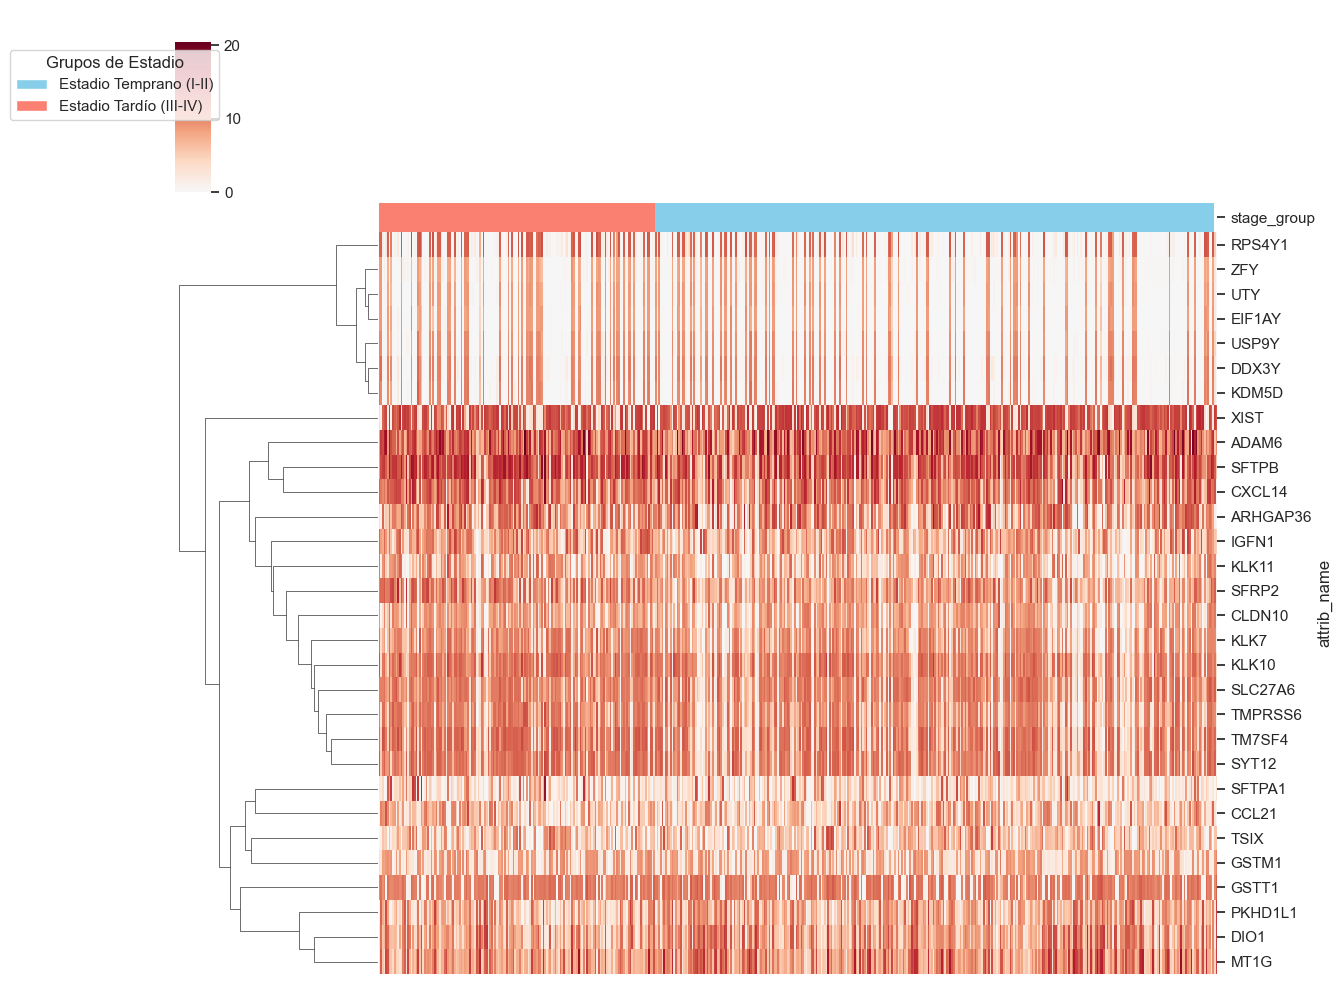

In [ ]:
# 1. Seleccionamos los genes más variables (puedes ajustar el número a 30 o 50)
genes_heatmap = df_rna_filtrado.var().sort_values(ascending=False).head(30).index

# 2. Ordenamos los datos para que la barra de color sea legible
df_sorted = df_combined.sort_values('stage_group')
matriz_exp = df_rna_filtrado.loc[df_sorted.index, genes_heatmap].T

# 3. Creamos el arreglo de colores para la diferenciación
# Mapeamos 'Temprano' a azul y 'Tardío' a rojo
colores_etiquetas = df_sorted['stage_group'].map({'Temprano': 'skyblue', 'Tardío': 'salmon'})

# 4. Dibujamos el Clustermap
g = sns.clustermap(
    matriz_exp,
    col_colors=colores_etiquetas, # Barra de diferenciación superior
    col_cluster=False,            # Mantiene el orden clínico (Temprano -> Tardío)
    row_cluster=True,             # Agrupa genes con patrones similares
    cmap='RdBu_r',                # Escala de Rojo (alto) a Azul (bajo)
    center=0,
    xticklabels=False,
    figsize=(12, 10),
    cbar_pos=(0.02, 0.8, 0.03, 0.15)
)

# 5. Añadimos la leyenda para identificar los colores de los estadios
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', label='Estadio Temprano (I-II)'),
                   Patch(facecolor='salmon', label='Estadio Tardío (III-IV)')]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.45, 1), loc='upper right', title="Grupos de Estadio")

plt.show()

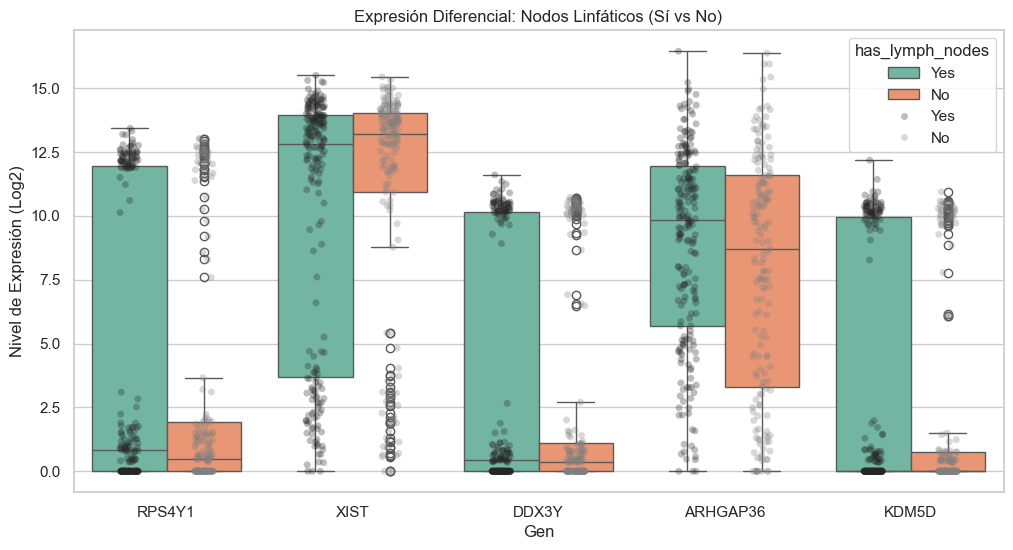

In [20]:
# 1. Preparamos los datos seleccionando los genes variables
genes_top = df_rna_filtrado.var().sort_values(ascending=False).head(5).index
df_plot = df_combined[['has_lymph_nodes']].join(df_rna_filtrado[genes_top])

# 2. Reestructuramos los datos para Seaborn de forma explícita
df_melted = df_plot.melt(id_vars='has_lymph_nodes', var_name='Gen', value_name='Expresion')

# 3. Creamos el gráfico
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Gen', y='Expresion', hue='has_lymph_nodes', palette='Set2')
sns.stripplot(data=df_melted, x='Gen', y='Expresion', hue='has_lymph_nodes', 
              dodge=True, alpha=0.3, palette='dark:grey')

plt.title('Expresión Diferencial: Nodos Linfáticos (Sí vs No)')
plt.ylabel('Nivel de Expresión (Log2)')
plt.show()

In [21]:
from scipy.stats import ttest_ind
import numpy as np

# 1. Separar los datos de expresión por grupo de estadio
early_exp = df_rna_filtrado.loc[df_combined[df_combined['stage_binary'] == 'Early (I-II)'].index]
late_exp = df_rna_filtrado.loc[df_combined[df_combined['stage_binary'] == 'Advanced (III-IV)'].index]

# 2. Calcular Log2 Fold Change y P-valor para cada gen
results = []
for gen in df_rna_filtrado.columns:
    # Media del grupo avanzado - Media del grupo temprano (en log2 es una resta)
    log2FC = late_exp[gen].mean() - early_exp[gen].mean()
    
    # Test t para ver si la diferencia es significativa
    t_stat, p_val = ttest_ind(late_exp[gen], early_exp[gen], nan_policy='omit')
    
    results.append({'gen': gen, 'log2FC': log2FC, 'pvalue': p_val})

df_volcano = pd.DataFrame(results)

# 3. Transformar p-valor a -log10 para el eje Y
df_volcano['neg_log10_p'] = -np.log10(df_volcano['pvalue'])

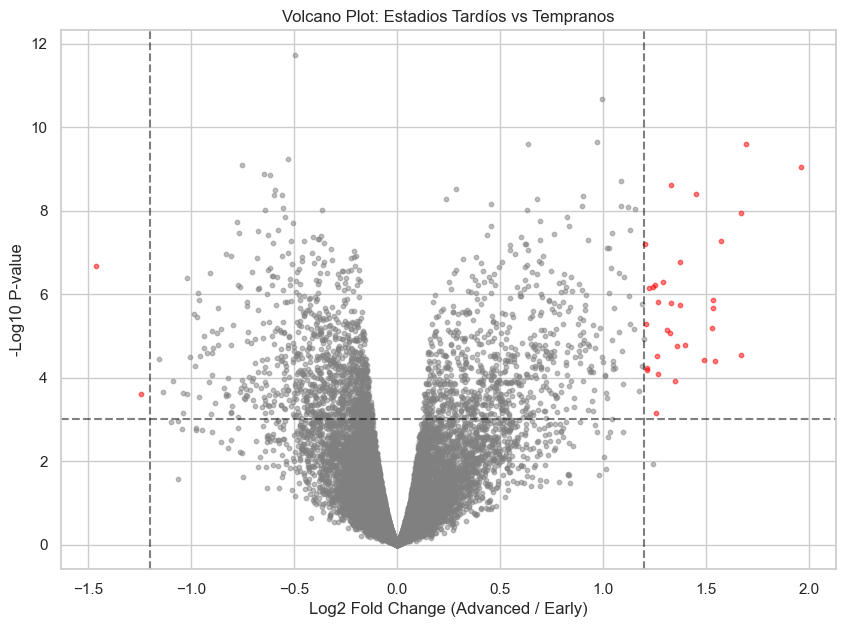

In [48]:
plt.figure(figsize=(10, 7))
# Definir umbrales (Significancia: p < 0.05 | Magnitud: |log2FC| > 1)
p_threshold = -np.log10(0.001)
fc_threshold = 1.2

# Colorear según significancia
for i, row in df_volcano.iterrows():
    if row['neg_log10_p'] > p_threshold and abs(row['log2FC']) > fc_threshold:
        color = 'red' # Genes significativos y con gran cambio
    else:
        color = 'grey' # Genes no interesantes
    plt.scatter(row['log2FC'], row['neg_log10_p'], color=color, alpha=0.5, s=10)

plt.axhline(y=p_threshold, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=fc_threshold, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=-fc_threshold, color='black', linestyle='--', alpha=0.5)

plt.title('Volcano Plot: Estadios Tardíos vs Tempranos')
plt.xlabel('Log2 Fold Change (Advanced / Early)')
plt.ylabel('-Log10 P-value')
plt.show()

Ahora guardamos en un nuevo DataFrame el nombre de los genes que estan diferencialmente expresados en el volcano plot

In [ ]:
# 1. Definimos los umbrales (usando los mismos de la gráfica)
p_threshold = 0.001
log2fc_threshold = 1.2

# 2. Filtramos los genes significativos
# Genes sobre-expresados (derecha) y sub-expresados (izquierda)
df_sig = df_volcano[(df_volcano['pvalue'] < p_threshold) & 
                    (df_volcano['log2FC'].abs() > log2fc_threshold)].copy()

# 3. Añadimos una columna para indicar si suben o bajan en estadios avanzados
df_sig['regulación'] = df_sig['log2FC'].apply(lambda x: 'UP' if x > 0 else 'DOWN')

# 4. Ordenamos por significancia estadística (-Log10 P-value)
df_sig = df_sig.sort_values('neg_log10_p', ascending=False)

# 5. Guardamos/Mostramos el nuevo DataFrame
df_genes_diferenciales = df_sig[['gen', 'log2FC', 'pvalue', 'regulación']]
print(f"Se han identificado {len(df_genes_diferenciales)} genes diferencialmente expresados.")
display(df_genes_diferenciales)

Se han identificado 34 genes diferencialmente expresados.


,gen,log2FC,pvalue,regulación
7882,MMP13,1.692706,2.563311e-10,UP
2947,COL11A1,1.956671,8.873630e-10,UP
13406,WISP2,1.327968,2.472335e-09,UP
2321,CCL17,1.449941,4.050488e-09,UP
6202,IVL,1.668044,1.114771e-08,UP
7355,LRRC15,1.570650,5.205137e-08,UP
8137,MYBPH,1.200056,6.126240e-08,UP
2946,COL10A1,1.374215,1.730445e-07,UP
2027,CA4,-1.460065,2.061181e-07,DOWN
2404,CD207,1.291854,5.076465e-07,UP


c:\Users\mbarr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


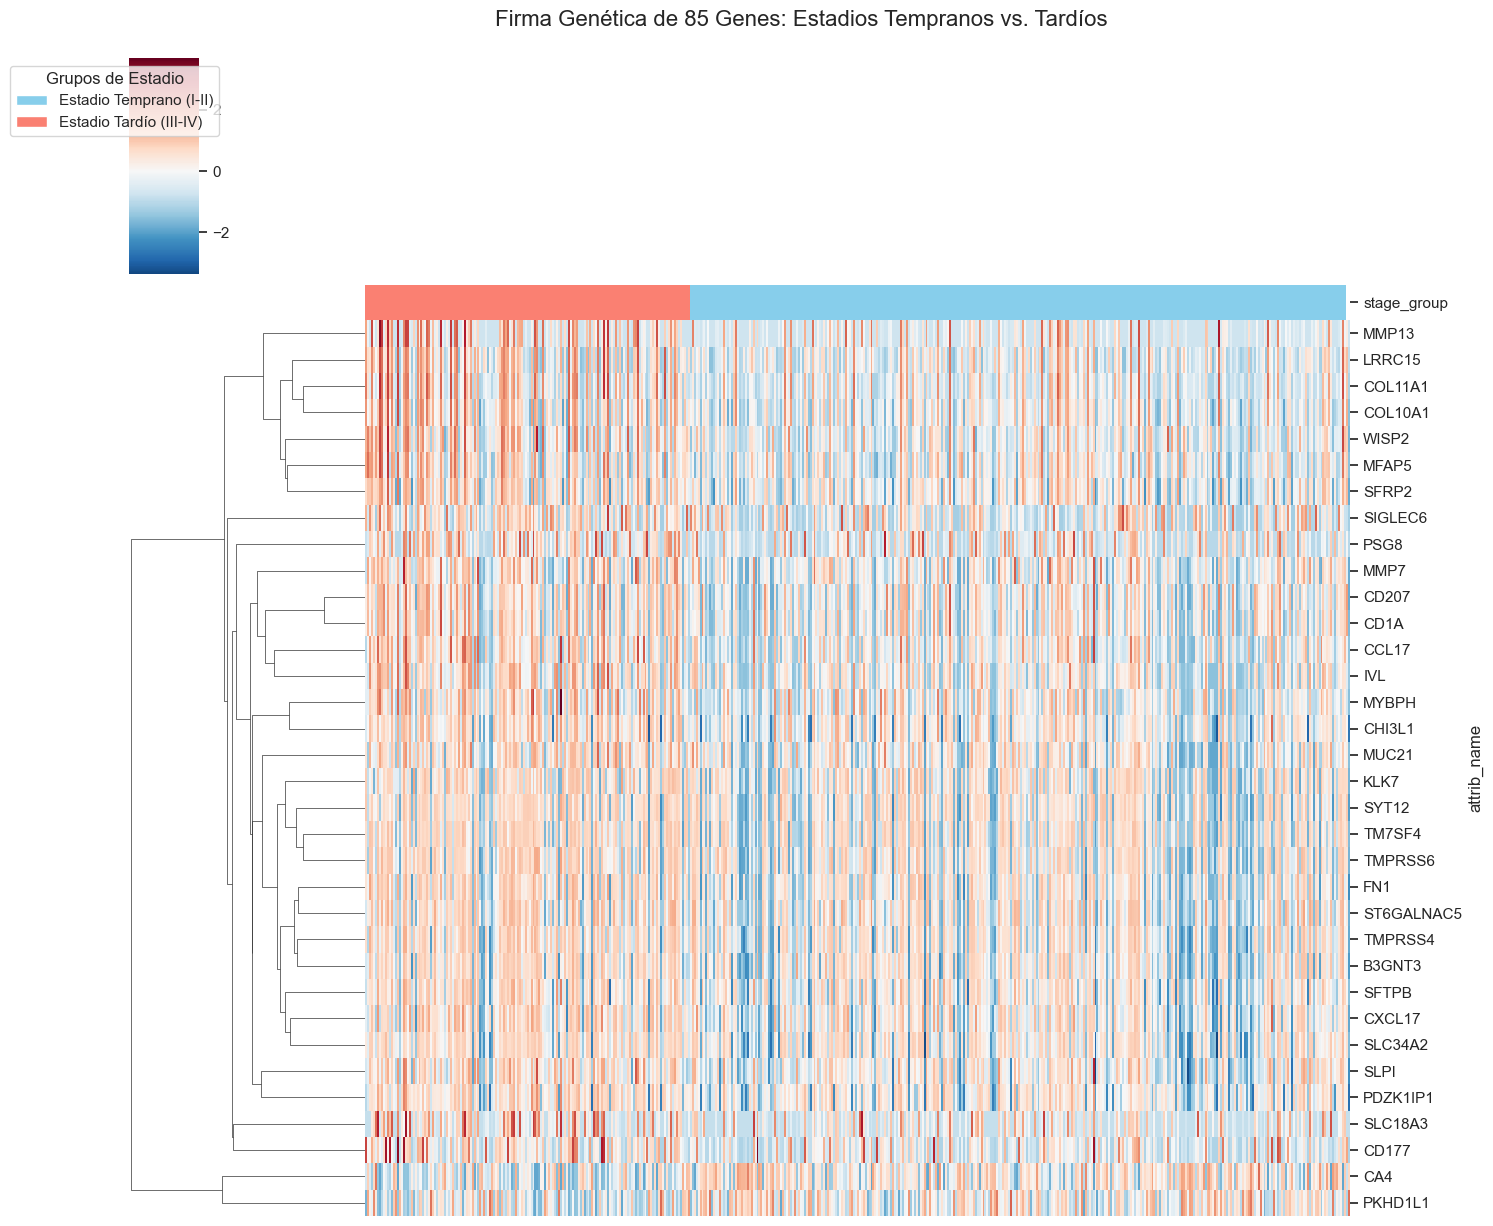

In [46]:
# 1. Extraemos la lista de genes significativos de tu dataframe del Volcano Plot
genes_significativos = df_genes_diferenciales['gen'].tolist()

# 2. Definimos de nuevo los grupos de estadio (Temprano vs Tardío)
stage_map = {
    'stagei': 'Temprano', 'stageii': 'Temprano',
    'stageiii': 'Tardío', 'stageiv': 'Tardío'
}
df_combined['stage_group'] = df_combined['pathologic_stage'].map(stage_map)

# 3. Preparamos la matriz de expresión filtrada solo con esos 85 genes
# Ordenamos pacientes por estadio para que la barra de color sea legible
df_sorted = df_combined.sort_values('stage_group')
matriz_exp_filtrada = df_rna_filtrado.loc[df_sorted.index, genes_significativos].T

# 4. Definimos los colores para la barra de diferenciación
colores_etiquetas = df_sorted['stage_group'].map({'Temprano': 'skyblue', 'Tardío': 'salmon'})

# 5. Dibujamos el Clustermap
# Nota: Si el error de scipy persiste, recuerda instalarlo y reiniciar el kernel
g = sns.clustermap(
    matriz_exp_filtrada,
    col_colors=colores_etiquetas,
    col_cluster=False,  # Mantenemos el orden por grupo para ver el contraste clínico
    row_cluster=True,   # Dejamos que los genes se agrupen por similitud de expresión
    cmap='RdBu_r', 
    center=0,
    z_score=0,          # Normalizamos por gen para resaltar cambios relativos
    xticklabels=False,
    figsize=(14, 12)
)

# 6. Añadimos leyenda para los estadios
legend_elements = [Patch(facecolor='skyblue', label='Estadio Temprano (I-II)'),
                   Patch(facecolor='salmon', label='Estadio Tardío (III-IV)')]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.4, 1), loc='upper right', title="Grupos de Estadio")

g.fig.suptitle('Firma Genética de 85 Genes: Estadios Tempranos vs. Tardíos', fontsize=16, y=1.02)
plt.show()

Ahora deberíamos buscar en una base de datos que guarde los genes que ya están descritos como biomarcadores, quedarnos con los que podrían ser nuevos. Tras ello, queremos pasar de Biomarcadores Aislados a "Equipos" Genéticos (Redes de Co-expresión) 
** ver documento con explicación

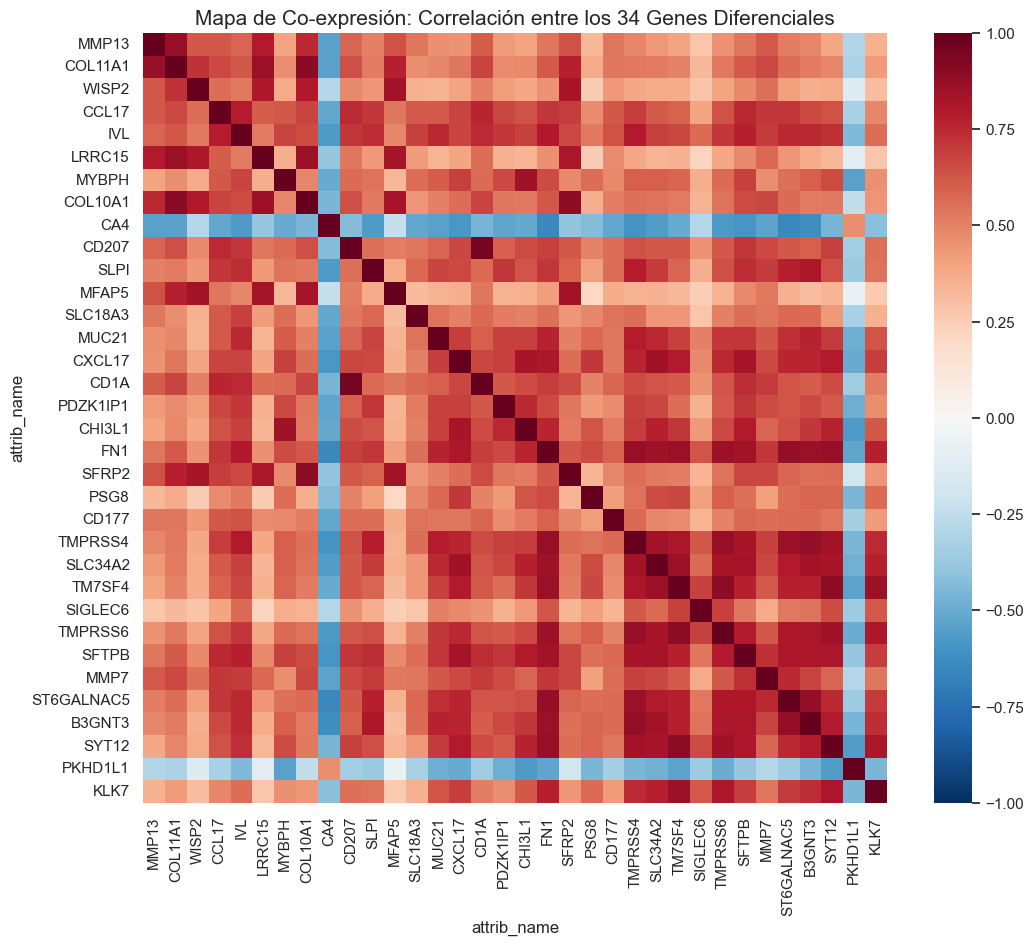

In [49]:
matriz_corr_diferencial = df_rna_filtrado[genes_significativos].corr()

# 3. Dibujar el Heatmap de Co-expresión
plt.figure(figsize=(12, 10))
sns.heatmap(
    matriz_corr_diferencial, 
    annot=False,          # False para que sea legible si hay muchos genes
    cmap='RdBu_r',        # Rojo para correlación positiva, Azul para negativa
    center=0,             # El blanco será correlación cero
    vmin=-1, vmax=1       # Rango estándar de correlación de Pearson
)

plt.title(f'Mapa de Co-expresión: Correlación entre los {len(genes_significativos)} Genes Diferenciales', fontsize=15)
plt.show()